In [11]:
import pandas as pd
import numpy as np
import ast
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, PCA
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# < -- LOAD DATA -- >
# Tracks with metadata
df_tracks = pd.read_csv("DATA/spotify_genius_data_noduplicates.csv")
df_tracks.rename(columns={"spotify_id": "song_id"}, inplace=True)

# Tokenized lyrics
tokenized_data = pd.read_csv("DATA/tokenized_data.csv")
tokenized_data["tokens_no_stop"] = tokenized_data["tokens_no_stop"].apply(ast.literal_eval)

# Community assignments
communities_df = pd.read_csv("DATA/communities.csv")

# < -- MERGE TRACKS WITH COMMUNITIES & SENTIMENT -- >
# Keep only songs with community info
df = df_tracks.merge(communities_df[["song_id", "community_id", "degree"]],
                     on="song_id", how="inner")

# Compute sentiment
analyzer = SentimentIntensityAnalyzer()
df["lyrics"] = df["lyrics"].fillna("")
df["sentiment"] = df["lyrics"].apply(lambda txt: analyzer.polarity_scores(txt)["compound"])

# Extract release year
df["year"] = pd.to_datetime(df["release_date"], errors="coerce", format="mixed").dt.year
df.dropna(subset=["year", "sentiment"], inplace=True)
df["year"] = df["year"].astype(int)

# < -- TOPIC MODELING -- >
# Prepare documents for topic modeling
tokenized_data = tokenized_data.rename(columns={"song_id": "song_id"})
tokenized_data["joined_lyrics"] = tokenized_data["tokens_no_stop"].apply(lambda toks: " ".join(toks))

# TF-IDF + NMF
tfidf = TfidfVectorizer(max_df=0.9, min_df=5, max_features=5000)
tfidf_matrix = tfidf.fit_transform(tokenized_data["joined_lyrics"])
nmf = NMF(n_components=10, random_state=0)
topic_matrix = nmf.fit_transform(tfidf_matrix)

# Assign dominant topic
tokenized_data["dominant_topic"] = topic_matrix.argmax(axis=1)

# < -- COMMUNITY-LEVEL THEMATICS -- >
# Build tokens_count per community
merged_tokens = (
    tokenized_data.explode("tokens_no_stop")[["song_id", "tokens_no_stop"]]
      .rename(columns={"tokens_no_stop": "token"})
      .merge(communities_df[["song_id", "community_id"]], on="song_id", how="inner")
)

community_tokens = (
    merged_tokens.groupby(["community_id", "token"])
                 .size()
                 .reset_index(name="count")
)

# Compute TF-IDF per community
totals = community_tokens.groupby("community_id")["count"].sum().reset_index(name="total")
tokens_count = community_tokens.merge(totals, on="community_id")
tokens_count["tf"] = tokens_count["count"] / tokens_count["total"]
df_dfreq = tokens_count.groupby("token")["community_id"].nunique().reset_index(name="df_comm")
N = tokens_count["community_id"].nunique()
tokens_count = tokens_count.merge(df_dfreq, on="token")
tokens_count["idf"] = np.log(N / tokens_count["df_comm"])
tokens_count["tf_idf"] = tokens_count["tf"] * tokens_count["idf"]

# Identify top 5 communities by distinct artist count
top_communities = (
    df.groupby("community_id")["primary_artist"]
      .nunique()
      .sort_values(ascending=False)
      .head(5)
      .index
      .tolist()
)

# < -- VISUALIZATIONS -- >
plt.style.use('default')

In [12]:
top_communities[:3]

[0, 1, 3]

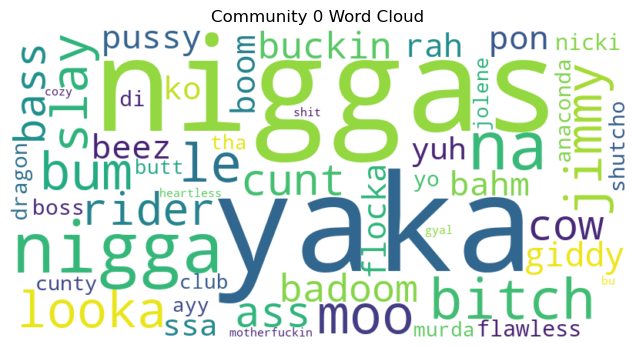

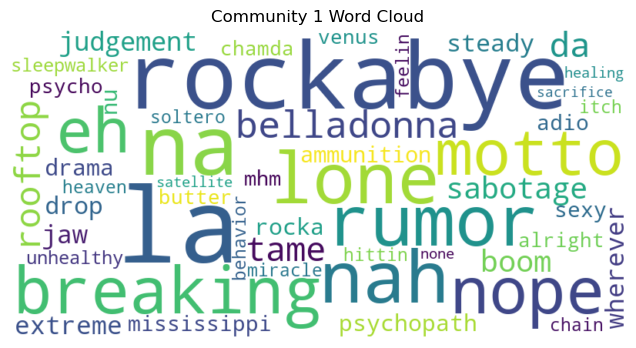

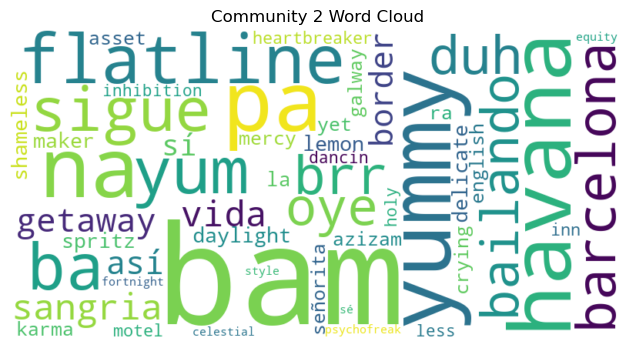

In [20]:
# Word clouds for top communities
for idx, cid in enumerate(top_communities[:3]):
    freqs = tokens_count.query("community_id==@cid and tf_idf>0") \
                        .nlargest(50, "tf_idf") \
                        .set_index("token")["tf_idf"].to_dict()
    if not freqs:
        continue
    wc = WordCloud(width=800, height=400, max_words=50,
                   background_color="white").generate_from_frequencies(freqs)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Community {idx} Word Cloud")
    plt.show()

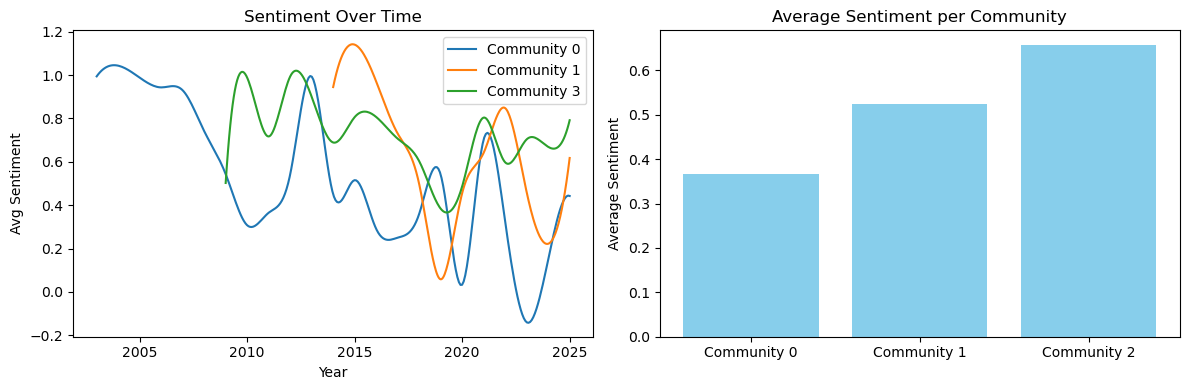

In [18]:
from scipy.interpolate import make_interp_spline

# Get top 3 community IDs (assumes top_communities is defined)
top3 = top_communities[:3]

labels = [0, 1, 2]

# Set up the figure
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# --- Left subplot: Smoothed line plot of sentiment over time ---
for cid in top3:
    grp = df[df["community_id"] == cid]
    yearly = grp.groupby("year")["sentiment"].mean()
    x = yearly.index.values
    y = yearly.values

    if len(x) >= 4:
        x_new = np.linspace(x.min(), x.max(), 300)
        spline = make_interp_spline(x, y, k=3)
        y_smooth = spline(x_new)
        axs[0].plot(x_new, y_smooth, label=f"Community {cid}")
    else:
        axs[0].plot(x, y, marker="o", label=f"Community {cid}")

axs[0].set_xlabel("Year")
axs[0].set_ylabel("Avg Sentiment")
axs[0].set_title("Sentiment Over Time")
axs[0].legend()

# --- Right subplot: Bar plot of average sentiment ---
avg_sentiments = (
    df[df["community_id"].isin(top3)]
    .groupby("community_id")["sentiment"]
    .mean()
)

axs[1].bar(
    range(len(top3)),
    avg_sentiments.values,
    color="skyblue"
)
axs[1].set_xticks(range(len(top3)))
axs[1].set_xticklabels([f"Community {cid}" for cid in labels])
axs[1].set_ylabel("Average Sentiment")
axs[1].set_title("Average Sentiment per Community")

plt.tight_layout()
plt.show()


In [ ]:
print(top_communities)

[0, 1, 3, 2, 4]


In [ ]:
df[df["community_id"] == 2]

,primary_artist,song_title,artists,release_date,popularity,is_collaboration,duration_seconds,song_id,lyrics,community_id,degree,sentiment,year
538,Ariana Grande,we can't be friends (wait for your love),Ariana Grande,2024-03-08,89,False,228.639,51ZQ1vr10ffzbwIjDCwqm4,I didn't think you'd understand me How could y...,2,18,0.9987,2024
539,Ariana Grande,twilight zone,Ariana Grande,2025-03-28,88,False,198.320,1YRbAonLvmuUILvQso0gUM,Did I dream the whole thing? Was I just a nigh...,2,18,-0.7829,2025
540,Ariana Grande,dandelion,Ariana Grande,2025-03-28,86,False,204.815,6wZOZ0votPhc8qdg4UFPtH,"Mean what I say, say what I mean Not one to pl...",2,18,0.9983,2025
541,Ariana Grande,One Last Time,Ariana Grande,2014-08-22,86,False,197.266,7xoUc6faLbCqZO6fQEYprd,"I was a liar, I gave in to the fire I know I s...",2,18,0.9911,2014
542,Ariana Grande,warm,Ariana Grande,2025-03-28,85,False,201.905,0BeR2fJmYnKNn7IORw3GR9,"I can find my way, never needed anybody to sta...",2,18,0.9978,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,Troye Sivan,Rush - Extended,Troye Sivan,2023-08-18,48,False,216.367,5OGXUPMmIKtrAlV4vrL3EE,I feel the rush Addicted to your touch Big com...,2,15,0.9992,2023
941,Troye Sivan,WILD,"Troye Sivan, Alessia Cara",2015-12-09,48,True,219.491,0xexXKZ1CAIrNHhTUX5Qkh,Trying hard not to fall On the way home You we...,2,15,-0.3348,2015
942,Troye Sivan,BITE,Troye Sivan,2015-12-09,47,False,186.052,4lvJOtynZbT08pZO10YoOv,Kiss me on the mouth and set me free Sing me l...,2,15,0.9991,2015
943,Troye Sivan,HEAVEN,"Troye Sivan, Betty Who",2015-12-09,47,True,261.114,2fNi8T6DLiY9SxFnZrhOeV,The truth runs wild Like a tear down a cheek T...,2,15,0.9856,2015


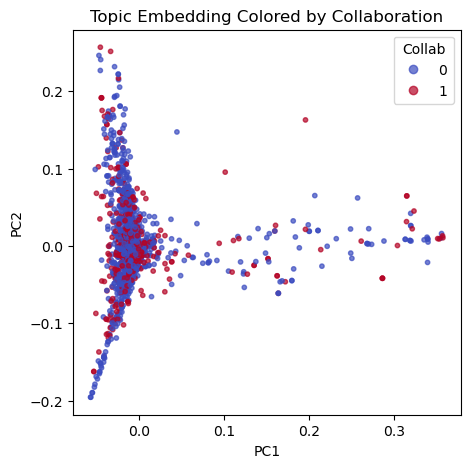

In [ ]:
# PCA of topics colored by collaboration flag
df_meta = df_tracks.merge(tokenized_data[["song_id", "dominant_topic"]], on="song_id", how="inner")
pc = PCA(n_components=2).fit_transform(topic_matrix)
colors = df_meta["is_collaboration"].map({True:1, False:0})
plt.figure(figsize=(5,5))
scatter = plt.scatter(pc[:,0], pc[:,1], c=colors, cmap="coolwarm", s=10, alpha=0.7)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("Topic Embedding Colored by Collaboration")
plt.legend(*scatter.legend_elements(), title="Collab"); plt.show()

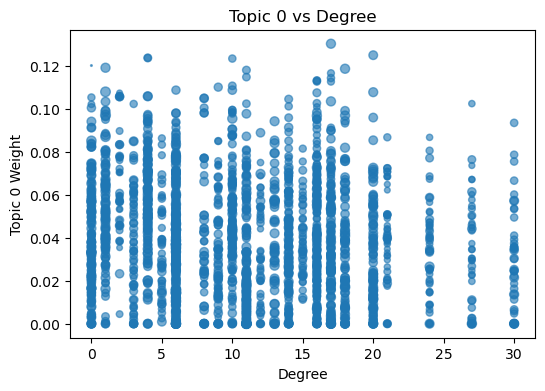

In [ ]:
# Topic 0 weight vs degree (collaboration count)
df_plot = df.merge(pd.DataFrame(topic_matrix, index=tokenized_data["song_id"])[0]
                   .reset_index().rename(columns={0:"topic0"}), on="song_id")
plt.figure(figsize=(6,4))
plt.scatter(df_plot["degree"], df_plot["topic0"], s=df_plot["popularity"]/2, alpha=0.6)
plt.xlabel("Degree"); plt.ylabel("Topic 0 Weight")
plt.title("Topic 0 vs Degree"); plt.show()